# Workforce Optimization

## Environment setup

In [13]:
import ipywidgets as widgets
from IPython.display import display, Javascript

def execute_cell(b):
    #display(Javascript('IPython.notebook.execute_cell(1)'))
    display(Javascript('IPython.notebook.execute_cells_below()'))

#Install glpk into Jupyter Hub
!conda install -c conda-forge -y glpk

button = widgets.Button(description="Initialize")
button.on_click(execute_cell)
display(button)



<IPython.core.display.Javascript object>

Button(description='Initialize', style=ButtonStyle())

In [14]:
from pyomo.environ import *
from ipydatagrid import DataGrid,TextRenderer, BarRenderer, VegaExpr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Javascript


cycle =  [1,2,3,4,5,6,7,8] #4 years cycle
year = [1,2,3,4]
stage = [1,2,3,4,5,6,7]
tran = [1,2,3] #1: stay, 2:promote, 3:drop

stage_name = ['Associate', 
                   'Consultant', 
                   'Senior Consultant', 
                   'Manager', 
                   'Senior Manager',
                   'Associate Partner',
                   'Partner']

stage_dict = dict( zip(stage, stage_name))
stage_dict['8'] =  'Exit'


#Headcount for each cycle
init_fte = [10,8,6,4,2,1,1]
headcnt_list = [ [5,4,3,2,1,1,1],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0]]

#Revenue per month year by title (unit: K$)
revenue = [20, 24, 30, 40, 50, 60, 80]


## Initial headcount

In [15]:


init_fte_df = pd.DataFrame([  {"title": "Associate", "12": 10, "24": 0, "36": 0, "48":0},
                              {"title": "Consultant", "12": 8, "24": 0, "36": 0, "48":0},
                              {"title": "Senior Consultant", "12": 6, "24": 0, "36": 0, "48":0},
                              {"title": "Manager", "12": 4, "24": 0, "36": 0, "48":0},
                              {"title": "Senior Manager","12": 2, "24": 0, "36": 0, "48":0},
                              {"title": "Associate Partner","12": 1, "24": 0, "36": 0, "48":0},
                              {"title": "Partner","12": 1, "24": 0, "36": 0, "48":0}
                           ])


init_fte_grid = DataGrid(init_fte_df, editable=True, layout={"height": "200px"},base_column_size=150)
init_fte_grid

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, base_column_size=150, corner_rendere…

In [16]:
init_fte_grid.data.iloc[2]["12"]

6

## Transition Probability

In [17]:
# Columns
col_top_level = [
    "12","12","12",
    "24","24","24",
    "36","36","36",
    "48","48","48"
]
col_bottom_level = ["Stay", "Promote", "Drop", 
                   "Stay", "Promote", "Drop", 
                   "Stay", "Promote", "Drop", 
                   "Stay", "Promote", "Drop"
                   ]

# Rows
row_top_level = ["Associate", "Consultant", "Senior Consultant", "Manager", "Senior Manager", "Associate Partner", "Partner"]

header_renderer = TextRenderer(
    background_color="moccasin",
    text_color="navy",
    vertical_alignment="top",
    horizontal_alignment="center",
)

default_renderer = TextRenderer(
    text_color=VegaExpr("cell.value <= 0 ? 'purple' : 'green'")
)

nested_df = pd.DataFrame(
    np.full((7,12),0),
    columns=pd.MultiIndex.from_arrays([col_top_level, col_bottom_level]),
    index=row_top_level
)


# Set initial values
tran_df = pd.DataFrame([  {"key": "Associate", 
                                               "12-Stay": 0.9, "12-Promote":0.02, "12-Drop":0.08, 
                                               "24-Stay": 0.59, "24-Promote":0.2, "24-Drop":0.21,
                                               "36-Stay": 0.65, "36-Promote":0.15, "36-Drop":0.2,
                                               "48-Stay": 0.65, "48-Promote":0.06, "48-Drop":0.29
                          },
                              {"key": "Consultant", 
                                               "12-Stay": 0.93, "12-Promote":0.002, "12-Drop":0.068, 
                                               "24-Stay": 0.78, "24-Promote":0.08, "24-Drop":0.14,
                                               "36-Stay": 0.78, "36-Promote":0.08, "36-Drop":0.14,
                                               "48-Stay": 0.89, "48-Promote":0.019, "48-Drop":0.091
                          },
                              {"key": "Senior Consultant", 
                                                "12-Stay": 0.89, "12-Promote":0.003, "12-Drop":0.107, 
                                               "24-Stay": 0.83, "24-Promote":0.06, "24-Drop":0.11,
                                               "36-Stay": 0.85, "36-Promote":0.07, "36-Drop":0.08,
                                               "48-Stay": 0.95, "48-Promote":0.02, "48-Drop":0.03
                          },
                              {"key": "Manager", 
                                               "12-Stay": 0.91, "12-Promote":0.0, "12-Drop":0.09, 
                                               "24-Stay": 0.86, "24-Promote":0.0, "24-Drop":0.14,
                                               "36-Stay": 0.87, "36-Promote":0.03, "36-Drop":0.1,
                                               "48-Stay": 0.91, "48-Promote":0.01, "48-Drop":0.08
                          },
                              {"key": "Senior Manager",
                                               "12-Stay": 0.94, "12-Promote":0.0, "12-Drop":0.06, 
                                               "24-Stay": 0.85, "24-Promote":0.05, "24-Drop":0.1,
                                               "36-Stay": 0.8, "36-Promote":0.07, "36-Drop":0.13,
                                               "48-Stay": 0.93, "48-Promote":0.02, "48-Drop":0.05
                          },
                              {"key": "Associate Partner",
                                               "12-Stay": 1, "12-Promote":0.0, "12-Drop":0.0, 
                                               "24-Stay": 0.91, "24-Promote":0.0, "24-Drop":0.09,
                                               "36-Stay": 0.9, "36-Promote":0.0, "36-Drop":0.1,
                                               "48-Stay": 0.89, "48-Promote":0.0, "48-Drop":0.11
                           },
                              {"key": "Partner",
                                               "12-Stay": 0.95, "12-Promote":0.0, "12-Drop":0.05, 
                                               "24-Stay": 0.94, "24-Promote":0.0, "24-Drop":0.06,
                                               "36-Stay": 0.82, "36-Promote":0.0, "36-Drop":0.18,
                                               "48-Stay": 0.85, "48-Promote":0.0, "48-Drop":0.15
                           }
                           ])


# Copy transition probabiliy into grid

for s in stage:
    for y in year:
        for t in tran:
            #print(f"s={s},y={y},t={t}")
            nested_df.iloc[s-1, 3*(y-1)+t-1] = tran_df.iloc[s-1, 3*(y-1)+t]
            
            
tran_grid = DataGrid(
    nested_df,
    base_column_size=80,
    base_column_header_size=35,
    base_row_header_size=80,
    layout={"height": "180px"},
    header_renderer=header_renderer,
    default_renderer=default_renderer,
    editable=True
)

tran_grid

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, base_column_header_size=35, base_col…

### 

## Execute Optimization

#### Push the button!

In [18]:
def execute_cell(b):
    #display(Javascript('IPython.notebook.execute_cell(1)'))
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run Optimization")
button.on_click(execute_cell)
display(button)

Button(description='Run Optimization', style=ButtonStyle())

In [19]:
#Maximum number of hiring for each position per cycle
bond_hire = [ (0,10),
             (0,10),
             (0,10),
             (0,5),
             (0,2),
             (0,1),
             (0,1)
             ]

#Minimum head count ratio (Span of control)
ratio_ast_mng = 2
ratio_con_mng = 2
ratio_sc_mng = 1
ratio_mng_sm = 2
ratio_mng_pt = 2.5
ratio_sm_pt = 2
ratio_sm_ap = 2

### MODEL CONSTRUCTION ###
#Declaration
model = ConcreteModel()

#Decision Variables
model.x = Var(range(70), domain=NonNegativeReals)


revenue = [20, 24, 30, 40, 50, 60, 80]
   

#FTE evolved from itself
fte_from_self = [ 
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]
                ]


#Calculate evolution of FTE for 5 years
    

for c in cycle:
    
    #derive year number from cycle number
    y_tmp = np.ceil(c/2).astype(int)
    
    for s in stage:
        total_fte = 0
        idx = (c-1)*len(stage) + s -1 #Relative position of hiring parameter
        if c == 1:
            #FTE = tran prob * initial FTE + additional hire
            
            #Staying FTE
            total_fte = total_fte + tran_grid.data.iloc[s-1, 3*(y_tmp-1)+0]*init_fte_grid.data.iloc[s-1]["12"]
                
            #Promoting FTE
            if s > 1:
                total_fte = total_fte + tran_grid.data.iloc[s-2, 3*(y_tmp-1)+1]*init_fte_grid.data.iloc[s-2]["12"]
            
            #New Hire
            total_fte = total_fte + model.x[idx]    
            fte_from_self[c-1][s-1] = total_fte

        else:
            #Staying FTE
            total_fte = total_fte + tran_grid.data.iloc[s-1, 3*(y_tmp-1)+0]*fte_from_self[c-2][s-1]
                
            #Promoting FTE
            if s > 1:
                total_fte = total_fte + tran_grid.data.iloc[s-2, 3*(y_tmp-1)+1]*fte_from_self[c-2][s-2]
            
            
            #New Hire
            total_fte = total_fte + model.x[idx]  
            fte_from_self[c-1][s-1] = total_fte
                             

np.rev = np.array(revenue)

np.fte0 = np.array(init_fte)

#np.fte1 = np.array(fte_from_self[0])
np.fte8 = np.array(fte_from_self[7])

#np.rev1 = np.sum(np.rev*np.fte1)
np.rev0 = np.sum(np.rev*np.fte0)


np.rev8  = np.sum(np.rev*np.fte8)
#growth = (np.rev10-np.rev1)/np.rev1

growth = (np.rev8-np.rev0)/np.rev0
    

            
np.fte = np.array(fte_from_self[1])
            
            

#Objective
#model.profit = Objective(expr=sum(np.fte),
#                     sense=maximize)

model.growth = Objective(expr=growth,
                     sense=maximize)


#model.growth.pprint()


model.fte_ratio = ConstraintList()

#Constraint
for c in cycle:
    
    ast_fte = fte_from_self[c-1][0]
    con_fte = fte_from_self[c-1][1]
    sc_fte = fte_from_self[c-1][2]
    mng_fte = fte_from_self[c-1][3]
    sm_fte = fte_from_self[c-1][4]
    ap_fte = fte_from_self[c-1][5]
    pt_fte = fte_from_self[c-1][6]   
    

    model.fte_ratio.add( expr = ast_fte -1*ratio_ast_mng*mng_fte  >= 0 )
    model.fte_ratio.add( expr = con_fte -1*ratio_con_mng*mng_fte  >= 0 )
    model.fte_ratio.add( expr = sc_fte  -1*ratio_sc_mng*mng_fte  >= 0 )
    model.fte_ratio.add( expr = mng_fte -1*ratio_mng_sm* sm_fte  >= 0 )
    model.fte_ratio.add( expr = mng_fte -1*ratio_mng_pt* pt_fte  >= 0 )
    model.fte_ratio.add( expr = sm_fte  -1*ratio_sm_pt*pt_fte  >= 0 )
    model.fte_ratio.add( expr = sm_fte  -1*ratio_sm_ap*ap_fte  >= 0 )

#Boundary
for c in cycle:
    for s in stage:
        idx = (c-1)*len(stage) + s -1 #Relative position of hiring parameter
        
        lower = 0
        upper =  bond_hire[s-1][1]
        
        model.fte_ratio.add (expr = model.x[idx] <= upper)
       
    
    
#model.fte_ratio.pprint()
    
solver = SolverFactory('glpk')
solver.solve(model)

### OUTPUT ###

# note that we're using f-strings for output here which is a little different and cleaner than in the video
print(f"Maximum Growth = {100*model.growth():,.2f}%")

hiring = np.zeros(56)

for i in range(56):
    hiring[i] = np.round(model.x[i]())
hiring_mtx = np.reshape(hiring, (8,7))
hiring_df = pd.DataFrame(hiring_mtx, columns=stage_name)

#hiring_df.to_csv(out_dir + '/hiring_plan_pyomo.csv', index = True)


#Generate FTE plan

fte_df = pd.DataFrame(columns=[  'cycle', 
                                 'Associate', 
                                 'Consultant', 
                                 'Senior Consultant', 
                                 'Manager',
                                 'Senior Manager',
                                 'Associate Partner',
                                 'Partner'
                                 ],
                      index=range(8))


for c in cycle:
    fte_df.iloc[c-1, 0] =  c
    for s in stage:
       fte_df.iloc[c-1, s]  = fte_from_self[c-1][s-1]()

#fte_df.to_csv(out_dir + '/fte_plan_pyomo.csv', index = False)


Maximum Growth = 472.04%


In [20]:
fte_df

,cycle,Associate,Consultant,Senior Consultant,Manager,Senior Manager,Associate Partner,Partner
0,1,19.0,17.64,15.356,6.430056,2.948709,1.474355,0.95
1,2,27.1,26.7852,23.70212,5.897419,2.948709,1.474355,0.9025
2,3,25.989,36.312456,31.815576,6.493908,2.978197,1.489098,0.84835
3,4,25.33351,43.521516,39.311924,10.470112,3.007979,1.503989,0.797449
4,5,26.466781,47.746809,46.896857,11.860832,3.128298,1.564149,1.564149
5,6,27.203408,51.212528,53.682073,13.601704,4.858463,2.429232,2.282602
6,7,27.682215,57.211354,61.971007,13.841108,5.880423,2.940212,2.940212
7,8,27.99344,62.579038,69.959473,13.99672,6.99836,3.49918,3.49918


In [21]:
hiring_df

,Associate,Consultant,Senior Consultant,Manager,Senior Manager,Associate Partner,Partner
0,10.0,10.0,10.0,3.0,1.0,0.0,0.0
1,10.0,10.0,10.0,0.0,0.0,0.0,0.0
2,10.0,10.0,10.0,0.0,0.0,0.0,0.0
3,10.0,10.0,10.0,3.0,0.0,0.0,0.0
4,10.0,10.0,10.0,0.0,0.0,0.0,1.0
5,10.0,10.0,10.0,0.0,2.0,1.0,1.0
6,10.0,10.0,10.0,0.0,1.0,1.0,1.0
7,10.0,10.0,10.0,0.0,1.0,1.0,1.0


<Axes: xlabel='cycle'>

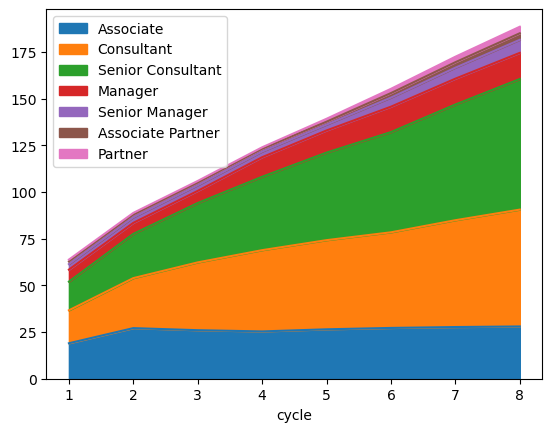

In [22]:
fte_df.plot.area(x='cycle')


In [23]:
tran_df

,key,12-Stay,12-Promote,12-Drop,24-Stay,24-Promote,24-Drop,36-Stay,36-Promote,36-Drop,48-Stay,48-Promote,48-Drop
0,Associate,0.90,0.020,0.080,0.59,0.20,0.21,0.65,0.15,0.20,0.65,0.060,0.290
1,Consultant,0.93,0.002,0.068,0.78,0.08,0.14,0.78,0.08,0.14,0.89,0.019,0.091
2,Senior Consultant,0.89,0.003,0.107,0.83,0.06,0.11,0.85,0.07,0.08,0.95,0.020,0.030
3,Manager,0.91,0.000,0.090,0.86,0.00,0.14,0.87,0.03,0.10,0.91,0.010,0.080
4,Senior Manager,0.94,0.000,0.060,0.85,0.05,0.10,0.80,0.07,0.13,0.93,0.020,0.050
5,Associate Partner,1.00,0.000,0.000,0.91,0.00,0.09,0.90,0.00,0.10,0.89,0.000,0.110
6,Partner,0.95,0.000,0.050,0.94,0.00,0.06,0.82,0.00,0.18,0.85,0.000,0.150
